# Clustering de documents

## Imports

In [4]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [5]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gatho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1]:
data_path = "../data/txt_clean/"

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [17]:
files1948 = [f for f in sorted(os.listdir(data_path)) if "_1948" in f]
files1949 = [f for f in sorted(os.listdir(data_path)) if "_1949" in f]
files1950 = [f for f in sorted(os.listdir(data_path)) if "_1950" in f]

In [19]:
# Exemple de fichiers
print(files1948[:5])
print(files1949[:5])
print(files1950[:5])

['KB_JB1051_1948-05-24_01-00003.txt', 'KB_JB1051_1948-05-27_01-00001.txt', 'KB_JB1051_1948-05-31_01-00001.txt', 'KB_JB1051_1948-06-02_01-00003.txt', 'KB_JB1051_1948-06-05_01-00003.txt']
['KB_JB1051_1949-01-03_01-00003.txt', 'KB_JB1051_1949-01-07_01-00003.txt', 'KB_JB1051_1949-01-08_01-00003.txt', 'KB_JB1051_1949-01-10_01-00001.txt', 'KB_JB1051_1949-01-10_01-00003.txt']
['KB_JB1051_1950-01-03_01-00003.txt', 'KB_JB1051_1950-01-12_01-00003.txt', 'KB_JB1051_1950-02-08_01-00003.txt', 'KB_JB1051_1950-02-22_01-00003.txt', 'KB_JB1051_1950-04-15_01-00003.txt']


In [20]:
texts1948 = [open(data_path + f, "r", encoding="utf-8").read() for f in files1948]
texts1949 = [open(data_path + f, "r", encoding="utf-8").read() for f in files1949]
texts1950 = [open(data_path + f, "r", encoding="utf-8").read() for f in files1950]

In [21]:
# Exemple de textes
texts1948[0][:400]

"LA GUERRE EN PALESTINE Le Conseil de Sécurité a décidé le « Cessez le feu » Washington, 22.\n\n— Les divergences entre les Etats-Unis et l'Angleterre au sujet de la Palestine se font' nettement jour.\n\nET LA FRANCE, On annonce, en effet, qu'un dé- LA GRANDE-BRETAGNE ET D'AUTRES, DONT LA BELGIQUE, puté va déposer sur le bureau de Divergences entre Londres et Washington au sujet des problèmes du Moyen-"

## Vectoriser les documents à l'aide de TF-IDF

In [22]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [23]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [25]:
tfidf_vectors_1948 = vectorizer.fit_transform(texts1948)
tfidf_vectors_1949 = vectorizer.fit_transform(texts1949)
tfidf_vectors_1950 = vectorizer.fit_transform(texts1950)

c:\Users\gatho\OneDrive\Documents\0_Tac_files\tac\tac_venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [32]:
# Détail d'une des matrices
tfidf_vectors_1949

<423x154 sparse matrix of type '<class 'numpy.float64'>'
	with 11550 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [37]:
pd.Series(
    tfidf_vectors_1950[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

i            0.699888
``           0.219496
jérusalem    0.195116
)            0.189803
(            0.179942
               ...   
etat         0.000000
entre        0.000000
encore       0.000000
e            0.000000
’            0.000000
Length: 112, dtype: float64

### Tests sur nos documents

In [40]:
tfidf_array_1948 = tfidf_vectors_1948.toarray()

In [41]:
# Vecteur du document 0
tfidf_array_1948[0]

array([0.        , 0.08931343, 0.        , 0.09937716, 0.06747353,
       0.08725884, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09454301,
       0.15454057, 0.        , 0.        , 0.        , 0.28555872,
       0.06850051, 0.        , 0.        , 0.08580734, 0.17451767,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.07589281, 0.0887861 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16795524, 0.08931343, 0.        , 0.        , 0.        ,
       0.        , 0.08931343, 0.        , 0.14247528, 0.        ,
       0.        , 0.        , 0.15242683, 0.05880304, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06217981,
       0.15178563, 0.        , 0.        , 0.        , 0.05937133,
       0.        , 0.        , 0.        , 0.        , 0.06902

In [42]:
# Vecteur du document 1
tfidf_array_1948[1]

array([0.16463804, 0.        , 0.14648529, 0.        , 0.        ,
       0.        , 0.        , 0.06708723, 0.12154011, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0758502 ,
       0.08900178, 0.        , 0.        , 0.06609604, 0.        ,
       0.22962138, 0.        , 0.        , 0.        , 0.        ,
       0.06785352, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06785352, 0.16463804, 0.        , 0.        ,
       0.08318444, 0.08846985, 0.        , 0.        , 0.        ,
       0.        , 0.08846985, 0.05977376, 0.        , 0.        ,
       0.        , 0.        , 0.05032905, 0.05824764, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.075176  , 0.        , 0.        , 0.        , 0.        ,
       0.08900178, 0.08900178, 0.        , 0.        , 0.06837

In [43]:
cosine(tfidf_array_1948[0], tfidf_array_1948[1])

0.608348899598395

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [96]:
N_CLUSTERS = 2

### Instancier le modèle K-Means et ses arguments

In [97]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [98]:
clusters = km_model.fit_predict(tfidf_vectors_1948)

c:\Users\gatho\OneDrive\Documents\0_Tac_files\tac\tac_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [99]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files1948[idx])

In [100]:
pprint(dict(clustering))

{0: ['KB_JB1051_1948-05-24_01-00003.txt',
     'KB_JB1051_1948-05-27_01-00001.txt',
     'KB_JB1051_1948-05-31_01-00001.txt',
     'KB_JB1051_1948-06-02_01-00003.txt',
     'KB_JB1051_1948-06-05_01-00003.txt',
     'KB_JB1051_1948-06-14_01-00003.txt',
     'KB_JB1051_1948-07-07_01-00003.txt',
     'KB_JB1051_1948-07-15_01-00003.txt',
     'KB_JB1051_1948-07-17_01-00003.txt',
     'KB_JB1051_1948-07-24_01-00003.txt',
     'KB_JB1051_1948-07-27_01-00003.txt',
     'KB_JB1051_1948-07-31_01-00003.txt',
     'KB_JB1051_1948-08-04_01-00003.txt',
     'KB_JB1051_1948-08-16_01-00003.txt',
     'KB_JB1051_1948-08-18_01-00003.txt',
     'KB_JB1051_1948-09-11_01-00004.txt',
     'KB_JB1051_1948-09-18_01-00001.txt',
     'KB_JB1051_1948-09-20_01-00003.txt',
     'KB_JB1051_1948-09-24_01-00003.txt',
     'KB_JB1051_1948-10-16_01-00003.txt',
     'KB_JB1051_1948-10-19_01-00003.txt',
     'KB_JB1051_1948-10-20_01-00003.txt',
     'KB_JB1051_1948-10-26_01-00002.txt',
     'KB_JB1051_1948-10-29_01-0000

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [101]:
pca = PCA(n_components=2)
reduced_vectors_1948 = pca.fit_transform(tfidf_vectors_1948.toarray())

In [102]:
reduced_vectors_1948[:10]

array([[-0.19186507, -0.1201986 ],
       [-0.19853217, -0.02872035],
       [-0.15986057, -0.00321593],
       [-0.23530511, -0.19573397],
       [-0.20384785, -0.00715341],
       [-0.1723336 , -0.115334  ],
       [-0.18757789, -0.12399419],
       [-0.13337178,  0.00523409],
       [-0.16523846, -0.18555316],
       [-0.20672651,  0.07169995]])

### Générer le plot

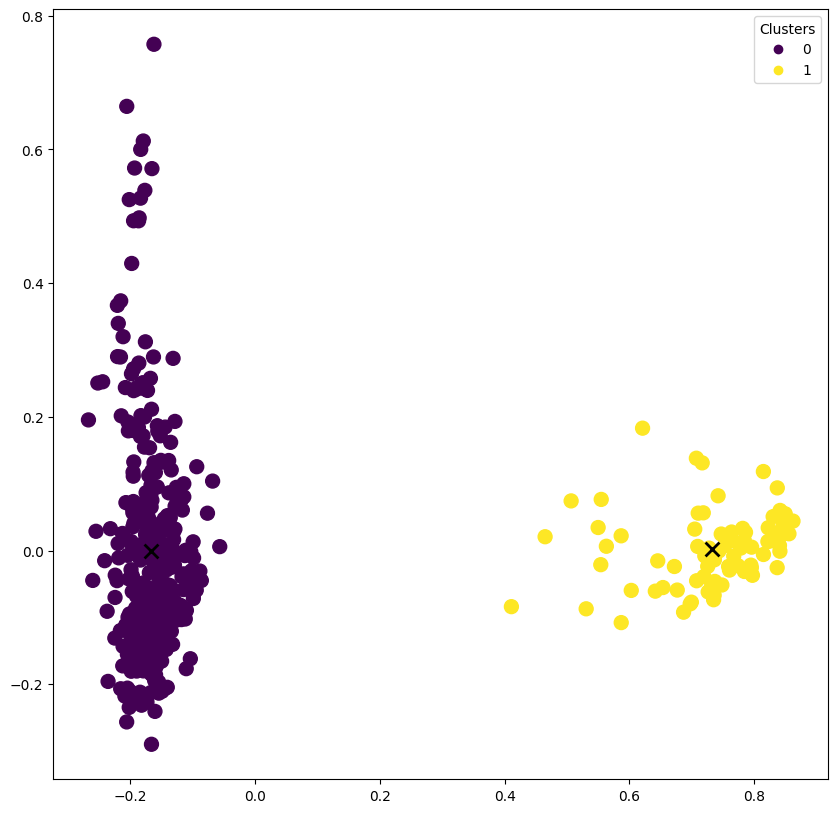

In [103]:
x_axis = reduced_vectors_1948[:, 0]
y_axis = reduced_vectors_1948[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

In [114]:
import shutil
import os

# Define the source and destination folders
source_folder = "../data/txt_clean/"
destination_folder = "../data/clustered_documents_1949/"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Iterate over the clusters
for label, files in clustering.items():
    # Create a folder for each cluster
    cluster_folder = os.path.join(destination_folder, f"Cluster_{label}")
    os.makedirs(cluster_folder, exist_ok=True)
    
    # Copy the documents of the cluster to the cluster folder
    for file in files:
        source_file = os.path.join(source_folder, file)
        destination_file = os.path.join(cluster_folder, file)
        shutil.copyfile(source_file, destination_file)


In [122]:
import os
import pandas as pd
from textblob import TextBlob

def calculate_polarity_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

base_directory = "../data/clustered_documents_1948/"
clusters = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

for cluster in clusters:
    results = []
    directory = os.path.join(base_directory, cluster)
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding="utf-8") as file:
                text = file.read()
                polarity, subjectivity = calculate_polarity_subjectivity(text)
                results.append([filename, polarity, subjectivity])

    df = pd.DataFrame(results, columns=['Document', 'Polarity', 'Subjectivity'])
    print(f"\nCluster: {cluster}")
    total_docs = len(df)
    count = len(df[(df['Polarity'] == 0) & (df['Subjectivity'] == 0)])
    print(f"The percentage of texts with 0 polarity and 0 subjectivity is: {count/total_docs*100}%")
    
    zero_subjectivity_negative_polarity_count = len(df[(df['Polarity'] < 0) & (df['Subjectivity'] == 0)])
    zero_subjectivity_positive_polarity_count = len(df[(df['Polarity'] > 0) & (df['Subjectivity'] == 0)])
    positive_subjectivity_zero_polarity_count = len(df[(df['Polarity'] == 0) & (df['Subjectivity'] > 0)])
    positive_subjectivity_negative_polarity_count = len(df[(df['Polarity'] < 0) & (df['Subjectivity'] > 0)])
    positive_subjectivity_positive_polarity_count = len(df[(df['Polarity'] > 0) & (df['Subjectivity'] > 0)])
    
    
    print(f"The percentage of texts with 0 subjectivity and negative polarity is: {zero_subjectivity_negative_polarity_count/total_docs*100}%")
    print(f"The percentage of texts with 0 subjectivity and positive polarity is: {zero_subjectivity_positive_polarity_count/total_docs*100}%")
    print(f"The percentage of texts with positive subjectivity and 0 polarity is: {positive_subjectivity_zero_polarity_count/total_docs*100}%")
    print(f"The percentage of texts with positive subjectivity and negative polarity is: {positive_subjectivity_negative_polarity_count/total_docs*100}%")
    print(f"The percentage of texts with positive subjectivity and positive polarity is: {positive_subjectivity_positive_polarity_count/total_docs*100}%")
    


Cluster: Cluster_0
The percentage of texts with 0 polarity and 0 subjectivity is: 40.229885057471265%
The percentage of texts with 0 subjectivity and negative polarity is: 0.8620689655172413%
The percentage of texts with 0 subjectivity and positive polarity is: 2.586206896551724%
The percentage of texts with positive subjectivity and negative polarity is: 16.091954022988507%
The percentage of texts with positive subjectivity and positive polarity is: 33.62068965517241%
The percentage of texts with positive subjectivity and 0 polarity is: 6.609195402298851%

Cluster: Cluster_1
The percentage of texts with 0 polarity and 0 subjectivity is: 22.78481012658228%
The percentage of texts with 0 subjectivity and negative polarity is: 1.2658227848101267%
The percentage of texts with 0 subjectivity and positive polarity is: 1.2658227848101267%
The percentage of texts with positive subjectivity and negative polarity is: 24.050632911392405%
The percentage of texts with positive subjectivity and po